In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import random 
import math
import statistics
import numpy_financial as npf

In [2]:
user = 2
if user == 1:
    path = "/Users/luongthilua/Documents/Financial planning/"
if user ==2:
    path = "/Users/lucadaquanno/Desktop/Documents/CIOS.Analyse/Return_forecasting/"

In [3]:
exclude_outlier = False # flag to indicate whether to restandardlized value should be used

In [4]:
df = pd.read_excel(path+"dsws_timeseries.xlsx", parse_dates = ["date"], index_col=("date"))

In [5]:
start_date = "2000-01-01"

In [6]:
end_date  = df.index.max() # end_date as given from user. for this test case its the last available date

In [7]:
df = df[start_date : end_date]

In [8]:
bdate = pd.bdate_range(start_date, end_date) # get only business day

In [9]:
df = df.copy()
for i in bdate:
    if (i in df.index) == False:
        df.loc[i,:] = np.nan

In [10]:
df = df.sort_index(ascending=True)

In [11]:
spline = False
if spline:
    df = df.interpolate(method = "cubic")
else:
    df = df.fillna(method = "ffill")

In [12]:
name = ["S&P500", "MSCI Europe","USD overall","EUR overall","Cash"]

In [13]:
df.columns = name

In [14]:
df

,S&P500,MSCI Europe,USD overall,EUR overall,Cash
date,,,,,
2000-01-03,2002.11,136.163,97.347,97.097,103.087
2000-01-04,1925.41,136.163,97.680,97.078,103.096
2000-01-05,1929.28,136.163,97.289,97.040,103.106
2000-01-06,1931.51,136.163,97.542,96.880,103.115
2000-01-07,1983.83,136.163,97.562,97.366,103.125
...,...,...,...,...,...
2020-04-03,5075.16,203.895,272.547,240.943,145.005
2020-04-06,5432.17,211.358,271.677,240.874,145.001
2020-04-07,5423.52,215.095,271.745,239.814,145.000


In [15]:
weight = [0.2,0.2,0.2,0.2,0.2]

In [16]:
holding_period = 200

In [17]:
n_mc = 100

In [18]:
freq = "D"

In [19]:
upscale_values = dict(
    D=1,
    W=4.83,
    M=21,
    Q=63,
    A=252
)

In [20]:
def get_upscale(value):
    """
   get scaling from daily to predefined frequency. same approach as in performance indicators
    """
    if type(value) == str:
        return float(upscale_values.get(value, 1))
    else:
        return value

#### convert daily returns to defined frequency returns

In [21]:
df_freq= df.resample(freq).last() #resample daily price to defined frequency

In [22]:
df

,S&P500,MSCI Europe,USD overall,EUR overall,Cash
date,,,,,
2000-01-03,2002.11,136.163,97.347,97.097,103.087
2000-01-04,1925.41,136.163,97.680,97.078,103.096
2000-01-05,1929.28,136.163,97.289,97.040,103.106
2000-01-06,1931.51,136.163,97.542,96.880,103.115
2000-01-07,1983.83,136.163,97.562,97.366,103.125
...,...,...,...,...,...
2020-04-03,5075.16,203.895,272.547,240.943,145.005
2020-04-06,5432.17,211.358,271.677,240.874,145.001
2020-04-07,5423.52,215.095,271.745,239.814,145.000


In [23]:
df_freq

,S&P500,MSCI Europe,USD overall,EUR overall,Cash
date,,,,,
2000-01-03,2002.11,136.163,97.347,97.097,103.087
2000-01-04,1925.41,136.163,97.680,97.078,103.096
2000-01-05,1929.28,136.163,97.289,97.040,103.106
2000-01-06,1931.51,136.163,97.542,96.880,103.115
2000-01-07,1983.83,136.163,97.562,97.366,103.125
...,...,...,...,...,...
2020-04-05,NaN,NaN,NaN,NaN,NaN
2020-04-06,5432.17,211.358,271.677,240.874,145.001
2020-04-07,5423.52,215.095,271.745,239.814,145.000


In [24]:
df_ret = df_freq.pct_change().dropna(how = "any")

In [25]:
df_ret

,S&P500,MSCI Europe,USD overall,EUR overall,Cash
date,,,,,
2000-01-04,-0.038310,0.000000,0.003421,-0.000196,0.000087
2000-01-05,0.002010,0.000000,-0.004003,-0.000391,0.000097
2000-01-06,0.001156,0.000000,0.002600,-0.001649,0.000087
2000-01-07,0.027088,0.000000,0.000205,0.005017,0.000097
2000-01-08,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2020-04-05,0.000000,0.000000,0.000000,0.000000,0.000000
2020-04-06,0.070345,0.036602,-0.003192,-0.000286,-0.000028
2020-04-07,-0.001592,0.017681,0.000250,-0.004401,-0.000007


In [26]:
# expected return 
exp_ret = np.array([0.20,0.07,0.005,0.006,0.002]) 

In [27]:
# expected vola
exp_vol = np.array([0.15, 0.20,0.05,0.06,0.03])

#### restandarlize return to incorporate user's view of portfolio future performance (expect return and volatility) into the sample
Ignore if there is no info on expected return and vola

In [28]:
df_ret = (df_ret - df_ret.mean())/df_ret.std(ddof=0)
df_ret = df_ret*(exp_vol/np.sqrt(get_upscale("A")/get_upscale(freq))) + exp_ret/(get_upscale("A")/get_upscale(freq))

In [29]:
port_ret = df_ret@weight

In [30]:
port_ret

date
2000-01-04   -0.005765
2000-01-05   -0.000725
2000-01-06    0.000492
2000-01-07    0.007608
2000-01-08   -0.000159
                ...   
2020-04-05   -0.000159
2020-04-06    0.020513
2020-04-07    0.001962
2020-04-08    0.005896
2020-04-09    0.011085
Freq: D, Length: 7402, dtype: float64

#### Bootstrapping starts 
Future returns is unknown. One of the methods to estimate future returns is to use historical return as the best estimate. 
This user story uses bootstrapping as method to estimate future return. It is the process of randomly picking out returns from a historical timeseries return and assign it as estimated future returns

In [31]:
# create estimated returns for monte carlo simulation, each path has timeseries return of holding_period return 
dada = np.random.choice(list(port_ret),(n_mc,holding_period)) #random.choices: sample with replacement

#### Monte carlo simulation of return
Each path takes one series of returns from bootstrapping, calculate cummulative returns and store data

In [32]:
port_fv = pd.DataFrame() # to store portfolio future value
port_fr = pd.DataFrame() # to store portfolio future return
for i in range(n_mc):
    if exclude_outlier:
        #please apply exclude_outlier configuration from Analyse, function below is just an example
        port_ret= sts.mstats.winsorize(port_ret, limits = 0.05).data 
    else:
        pass
    da = dada[i] # taking one return series from bootstrapped returns
    port_fr_i = pd.DataFrame((1+da).cumprod()) # cumulative future returns
    port_fr = pd.concat([port_fr, port_fr_i - 1], axis = 1)


In [33]:
quantile = [0.01,0.5,0.99]
final_result = pd.DataFrame()
for i in quantile:
    final_result.loc[:,"{0}".format(i)] = port_fr.quantile(i, axis = 1)

<AxesSubplot:>

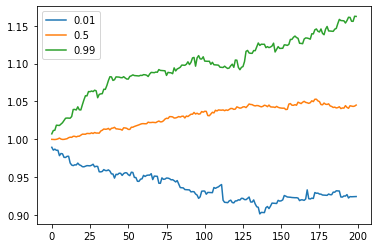

In [34]:
(1+final_result).plot()